In [1]:
import os
import sys 
import math
# Import GPyTorch
import gpytorch

import numpy as np # linear algebra
from scipy.stats import randint
import matplotlib.pyplot as plt # this is used for the plot the graph 
%matplotlib inline
from tqdm import notebook
from scipy import stats
from scipy.interpolate import interp1d
import time

import torch

import gpytorch
# Import exact GP model


from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

# Import GPyTorch mean and covariance kernel functions
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, SpectralMixtureKernel


# Import GPyTorch distribution and likelihood
# MultivariateNormal a multivariate normal random variable
from gpytorch.distributions import MultivariateNormal
# GPyTorch likelihood specifies the mapping from latent function values observed labels
from gpytorch.likelihoods import GaussianLikelihood
# module that calculates the exact marginal log likelihood (MLL)
from gpytorch.mlls import ExactMarginalLogLikelihood

from torch.utils.data import TensorDataset, DataLoader



import tqdm





### simulate data

In [2]:
dt=np.load('energydt.npy')

# the full design matrix
x=dt[:,:-1]
y=dt[:,-1]
ntrain=int(np.floor(len(x)*0.6))
stats.describe(y)

DescribeResult(nobs=1441, minmax=(-2.2052207299156037, 5.333679641267546), mean=-0.0032660240952695646, variance=0.985302073606261, skewness=0.5683701905151197, kurtosis=1.3028270149021273)

### PPGPR Model

https://arxiv.org/pdf/1910.07123.pdf

In [3]:
class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Ten Replications to evaluate the hard metrics

In [4]:
##function to create replication
def rep_iter(x,y,frac=0.4):
    n=len(x)
    ntest=int(np.floor(frac*n))
    allidx=np.random.permutation(n)
    trainidx= allidx[ntest:]
    testidx= allidx[:ntest]
    return x[trainidx],y[trainidx],x[testidx],y[testidx]
    

In [5]:
#initialize the metric
ppgprll=[]
ppgprcal=[]
ppgprcalshp=[] #empirical coverage
ppgprwidth=[] #empirical width
ppgpr90=[] #90 interval coverage
ppgprmae=[]

In [6]:
np.random.seed(2021)
for a in range(10):
    train_x,train_y,test_x,test_y=rep_iter(x,y)
    ntrain=len(train_x)
    ntest=len(test_x)

    # Convert to PyTorch tensors and place
    train_y = torch.from_numpy(train_y).float()
    train_x = torch.from_numpy(train_x).float()
    test_x = torch.from_numpy(test_x).float()
    
    #data loader
    train_dataset = TensorDataset(train_x, train_y)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    inducing_points = train_x[:500,:] #if training set is small, all set as inducing point
    model = GPModel(inducing_points=inducing_points)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=0.01)

    # Our loss object. We're using the VariationalELBO
    mll = gpytorch.mlls.PredictiveLogLikelihood(likelihood, model, num_data=train_y.numel())

    epochs_iter = tqdm.notebook.tqdm(range(300), desc="Epoch")
    for i in epochs_iter:
        # Within each iteration, we will go over each minibatch of data
        minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
        for x_batch, y_batch in minibatch_iter:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            minibatch_iter.set_postfix(loss=loss.item())
            loss.backward()
            optimizer.step()


    model.eval()
    likelihood.eval()
    with torch.no_grad():
        preds = model(test_x)

    ppgprmu=preds.mean.detach().numpy()
    ppgprstd=preds.stddev.detach().numpy()   

    
    #####calculate metrics##############

    per=np.linspace(0.02,0.98,8) #quantile to study calibration
    pershp=np.linspace(0.4,0.999,20) #nominal quantile to study sharpness


    ppgprc=[]

    for i in per:
        lquantile=(stats.norm.ppf(0.5-i/2.)*ppgprstd+ppgprmu)
        rquantile=(stats.norm.ppf(0.5+i/2.)*ppgprstd+ppgprmu)
        ppgprc.append(np.mean((test_y.ravel()<rquantile.ravel())*(test_y.ravel()>lquantile.ravel())))

    ppgprcal.append(ppgprc)
    
    
    
    ppgprc1=[]    
    ppgprwid=[]
    for i in pershp:
        lquantile=(stats.norm.ppf(0.5-i/2.)*ppgprstd+ppgprmu)
        rquantile=(stats.norm.ppf(0.5+i/2.)*ppgprstd+ppgprmu)
        ppgprc1.append(np.mean((test_y.ravel()<rquantile.ravel())*(test_y.ravel()>lquantile.ravel())))
        ppgprwid.append(np.median(rquantile-lquantile))
        
        
    ppgprcalshp.append(np.array(ppgprc1))    
    ppgprwidth.append(np.array(ppgprwid))
    
    
    #ninty
    l90=(stats.norm.ppf(0.5-0.9/2.)*ppgprstd+ppgprmu)
    r90=(stats.norm.ppf(0.5+0.9/2.)*ppgprstd+ppgprmu)
    ppgpr90.append(np.mean((test_y.ravel()<r90.ravel())*(test_y.ravel()>l90.ravel())))
    
    #log likelihood
    low=np.quantile(test_y,0.05)
    high=np.quantile(test_y,0.95)
    itv=np.linspace(low,high,9)
    itv=np.append(-np.infty,itv)
    itv=np.append(itv,np.infty)
    #outcome1 belongs to which interval
    id=np.zeros(len(test_y))
    for i in range(10):
        id=id+1*(test_y.ravel()>itv[i+1])
    id=id.astype('int')

    l=(itv[id]-ppgprmu)/ppgprstd
    r=(itv[id+1]-ppgprmu)/ppgprstd
    prtmp=stats.norm.cdf(r)-stats.norm.cdf(l)
    ll_est=np.log(prtmp+1e-10)
    ppgprll.append(ll_est.mean())
    
    #mae
    ppgprmae.append(np.abs(ppgprmu-test_y.ravel()).mean()) #regular def





In [7]:
def musd(x):
    print(np.mean(x),np.std(x))

musd(ppgprll)
musd(ppgpr90)
musd(ppgprmae)



-2.121752894000805 0.06326179079694326
0.7729166666666667 0.023029499164986693
0.5698779882366072 0.015849170458589194


In [8]:
#calibration
def calcompu(x):
    x=np.array(x)
    n=len(x)
    cal=np.mean(x,0)
    calest=np.abs(x-per).mean(1)
    
    print(np.mean(calest),np.std(calest))
    
    return  cal

ppgprcalplot=calcompu(ppgprcal)

0.06978819444444448 0.011659935485856528


In [16]:
ppgprcalplot

array([0.01805556, 0.13246528, 0.25711806, 0.36614583, 0.47534722,
       0.59635417, 0.71770833, 0.88125   ])

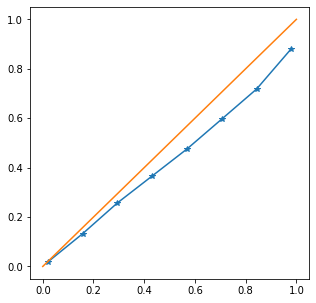

In [10]:
## calibration plot
plt.figure(figsize=(5,5))
plt.plot(per,ppgprcalplot,'-*')

plt.plot([0,1],[0,1])

In [11]:
def shpplt(cal,width): #median interval width calculation
    n=len(cal)
    cal=np.array(cal)
    width=np.array(width)
    low=np.max(cal[:,0])
    up=np.min(cal[:,-1])
    rangeint=np.linspace(low,up,30)
    widest=[]
    for i in range(n):
        widest.append(interp1d(cal[i],width[i])(rangeint))
    
    return rangeint,np.array(widest).mean(0)

    

In [12]:
ppgprempcal,ppgprempwid=shpplt(ppgprcalshp,ppgprwidth)

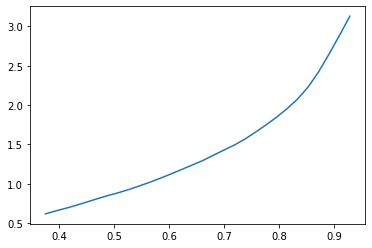

In [13]:
plt.plot(ppgprempcal,ppgprempwid)